In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import warnings

# Import API key
from zw_config import g_key

# Ignore unnecessary gmaps warning
warnings.filterwarnings('ignore')

In [3]:
# Read in original CSV as new dataframe
crime_df = pd.read_csv("../crime_data/october_2017_LA_data.csv")
crime_df.head()

,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Weapon Desc,LAT,LON
0,10/22/2017,1400,Topanga,THEFT,NaN,34.1911,-118.5644
1,10/12/2017,900,West Valley,VANDALISM,NaN,34.2029,-118.5513
2,10/10/2017,1930,West Valley,ASSAULT,MACE/PEPPER SPRAY,34.1775,-118.5338
3,10/11/2017,1700,Harbor,VANDALISM,NaN,33.8613,-118.2962
4,10/3/2017,1050,Central,THEFT,NaN,34.0563,-118.2374


In [4]:
# Find the closest fast food restaurant to each set of coordinates
# ----------------------------------
# *Do not run cell again as to avoid overcharge and massive time delay
# *Instead just refer to restaurants.csv for results of this cell's code
# ----------------------------------

# Google API used to find nearby restaurants
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

# Set parameters for the API url
params = {
    "rankby": "distance",
    "types": "restaurant",
    "keyword": "fast food",
    "key": g_key
}

# Loop through entire dataframe to retrieve closest restaurant to each set of coordinates
for index, row in crime_df.iterrows():
    
    # get coordinates from dataframe
    lat = row["LAT"]
    lng = row["LON"]

    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"

    # make request
    name_address = requests.get(base_url, params=params)

    # convert and reassign variable to json
    name_address = name_address.json()

    # Since some data may be missing we incorporate a try-except to skip any that are missing a data point
    # Add results of the API call as colums to crime_df
    try:
        crime_df.loc[index, "Closest Restaurant"] = name_address["results"][0]["name"]
        crime_df.loc[index, "Restaurant Address"] = name_address["results"][0]["vicinity"]
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")
    break

In [5]:
# View dataframe resulting from API call in previous cell
crime_df.head()

,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Weapon Desc,LAT,LON,Closest Restaurant,Restaurant Address
0,10/22/2017,1400,Topanga,THEFT,NaN,34.1911,-118.5644,Del Taco,"19644 Vanowen St, Reseda"
1,10/12/2017,900,West Valley,VANDALISM,NaN,34.2029,-118.5513,NaN,NaN
2,10/10/2017,1930,West Valley,ASSAULT,MACE/PEPPER SPRAY,34.1775,-118.5338,NaN,NaN
3,10/11/2017,1700,Harbor,VANDALISM,NaN,33.8613,-118.2962,NaN,NaN
4,10/3/2017,1050,Central,THEFT,NaN,34.0563,-118.2374,NaN,NaN


In [6]:
# Export New Dataframe to CSV
crime_df.to_csv("LA_restaurants.csv", index=False)

In [8]:
# Read in CSV as dataframe to use for all further analysis
restaurants_df = pd.read_csv("LA_restaurants.csv")
restaurants_df.head()

,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Weapon Desc,LAT,LON,Closest Restaurant,Restaurant Address
0,10/22/2017,1400,Topanga,THEFT,NaN,34.1911,-118.5644,Del Taco,"19644 Vanowen St, Reseda"
1,10/12/2017,900,West Valley,VANDALISM,NaN,34.2029,-118.5513,NaN,NaN
2,10/10/2017,1930,West Valley,ASSAULT,MACE/PEPPER SPRAY,34.1775,-118.5338,NaN,NaN
3,10/11/2017,1700,Harbor,VANDALISM,NaN,33.8613,-118.2962,NaN,NaN
4,10/3/2017,1050,Central,THEFT,NaN,34.0563,-118.2374,NaN,NaN


In [12]:
# Drop unnecessary columns from dataframe
by_address = restaurants_df[['Closest Restaurant', 'Restaurant Address','LAT','LON']]

# Isolate the 10 (or however many desired) specific restaurants (by address, not franchise)
# with the highest number of nearby crimes, from highest to lowest
# ----------------------------------
# *Note - .value_counts() only creates a dataframe that consists of a single series
# which must be merged into original dataframe afterword
# ----------------------------------
top_ten = pd.DataFrame(by_address['Restaurant Address'].value_counts().head(10))
top_ten = top_ten.reset_index()
top_ten.columns = ['Restaurant Address', 'Number of Crimes']

# Merge top ten restaurants with their nearby crime counts with original dataframe
top_ten = pd.merge(top_ten,restaurants_df,on='Restaurant Address')

# Drop all unnecessary columns after merge and organize new dataframe
top_ten = top_ten[['Closest Restaurant','Restaurant Address','LAT','LON','Number of Crimes']]
top_ten.rename(columns ={'Closest Restaurant':'Restaurant',
                         'Restaurant Address':'Address'})

# Only show each restaurant once
top_ten = top_ten.drop_duplicates(subset = 'Restaurant Address').reset_index()

# Drop column with original indeces
del top_ten['index']

# View resulting dataframe
top_ten

,Closest Restaurant,Restaurant Address,LAT,LON,Number of Crimes
0,Del Taco,"19644 Vanowen St, Reseda",34.1911,-118.5644,1


In [14]:
# Configure gmaps
gmaps.configure(api_key=g_key)

# Template for map markers
info_box_template = """
<dl>
<dt>Restaurant</dt><dd>{Closest Restaurant}</dd>
<dt>Address</dt><dd>{Restaurant Address}</dd>
<dt>Number of Crimes Nearby</dt><dd>{Number of Crimes}</dd>
</dl>
"""

# Assign variable to dataframe row to use on markers
restaurant_info = [info_box_template.format(**row) for index, row in top_ten.iterrows()]

# Assign variable for marker layer to dataframe coordinates
locations = top_ten[["LAT", "LON"]]

# Display map
fig = gmaps.figure()

# Assign and add marker layer including restaurant information
marker_layer = gmaps.marker_layer(locations, info_box_content=restaurant_info)
fig.add_layer(marker_layer)

# Display Map with clickable marker info boxes
fig

Figure(layout=FigureLayout(height='420px'))

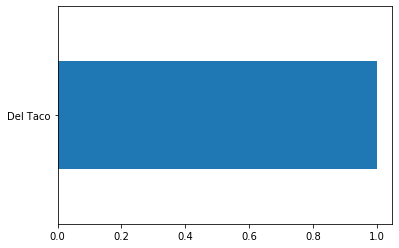

In [15]:
# Bar graph of top ten most dangerous restaurants in NYC by franchise
restaurants_df['Closest Restaurant'].value_counts().head(20).sort_values(ascending=True).plot.barh()

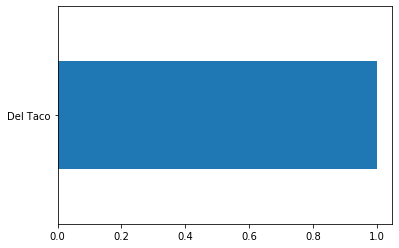

In [16]:
# Find number of fast food restaurants all in all in NYC to compare
unique_restaurants_df = restaurants_df.drop_duplicates(subset = 'Restaurant Address').reset_index()
restaurant_count = unique_restaurants_df['Closest Restaurant'].value_counts().head(20).sort_values(ascending=True).plot.barh()